<a href="https://colab.research.google.com/github/joywang233/topic_models_for_cyberthreats/blob/main/TDM_topic_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install packages

In [ ]:
!pip install --upgrade gensim
!pip install transformers
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.3 MB/s 
     |████████████████████████████████| 6.6 MB 44.9 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.7 MB/s 
     |████████████████████████████████| 1.2 MB 10.9 MB/s 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

%cd /content/gdrive/MyDrive/PHD-2022/log4j_all_data
import pandas as pd
import numpy as np
import re #for tokenization
import io
import glob
import os
from collections import Counter
import collections
import time
import resource
#########################################
import pandas as pd
import pickle
import random
import datetime

SEED = 999
random.seed(SEED)
np.random.seed(SEED)
num_topics = 12

from sentence_transformers import SentenceTransformer
import gensim
from gensim import corpora,models
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec, KeyedVectors, ldamodel
#########################################

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.utils import check_array
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import combinations
from scipy.spatial.distance import cosine
###################################BERT
import torch
from numpy import asarray, save
from transformers import BertTokenizer, BertForMaskedLM, BertConfig
###################################
from preprocessing import WhiteSpacePreprocessingStopwords

Mounted at /content/gdrive
/content/gdrive/MyDrive/PHD-2022/log4j_all_data


### Load the Log4Shell data

In [ ]:
New_log4j = pd.read_csv('/content/gdrive/MyDrive/PHD-2022/log4j_all_data/log4jdf_all.csv', encoding = 'utf8')
New_log4j['created_at']= pd.to_datetime(New_log4j['created_at'], dayfirst=True, errors='coerce')
mask = (New_log4j['created_at'] > '2021-11-23')
new_filtered = New_log4j.loc[mask]

new_filtered['text'] = new_filtered['text'].str.replace('rt', ''.strip()) #here is to remove rt
new_filtered['process_text'] = new_filtered['process_text'].str.replace('rt', ''.strip())
new_filtered['text'] = new_filtered['text'].str.replace('gt', ''.strip())
new_filtered['process_text'] = new_filtered['process_text'].str.replace('gt', ''.strip()) #here is to remove gt
new_filtered['text']  = new_filtered['text'].str.strip()
new_filtered['process_text']  = new_filtered['process_text'].str.strip()
new_filtered['process_text']  = new_filtered['process_text'].str.replace(r'\b(\w{1,3})\b', ''.strip())   #Remove words with character less than 2
new_filtered['process_text']  = new_filtered['process_text'].str.strip() #remove extra spaces
valid_df = new_filtered.loc[new_filtered.process_text.str.split().str.len() >= 3] #remove sentence with less two words
train_df = valid_df

id                      object
created_at      datetime64[ns]
text                    object
location                object
user                    object
Time                    object
label                  float64
process_text            object
dtype: object


### Dynamic topic visualizations

In [ ]:
#Visualization
sns.set(style="whitegrid", font_scale=1, context="talk")
num_topics = 10


def create_time_slice(df):
  time_df = df.copy(deep=True)
  time_df.created_at = pd.to_datetime(time_df.created_at, dayfirst=True, errors='coerce')
  time_df.Time = time_df.created_at.dt.date
  time_slice = time_df.groupby(time_df.Time).count().iloc[:,0].values
  new_list = [] #save indexs for slicing the topic X document matrix
  base = 0
  for i in range(len(time_slice)):
    base = base + time_slice[i]
    new_list.append(base-1)

  time_df.Time = time_df.created_at.dt.strftime('%m-%d')
  date_list = time_df.Time.unique()
  return (new_list, date_list)


def heatmap(
    data,
    x_tick_labels,
    x_label,
    y_tick_labels,
    y_label,
    figsize=(7, 24),
    max_data=None,
):
    """Plot heatmap.
    Args:
        data: (2d array) data to be plotted (topics x date)
        x_tick_labels (list of str)
    Returns:
        fig
        ax
    """

    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(
        data,
        rasterized=True,
        vmax=max_data,
        cbar_kws=dict(use_gridspec=False, location="top", aspect =80),
        )

    plt.xticks(rotation=45)
    plt.yticks(np.arange(0, data.shape[0], 1.0) + 0.5, rotation=0)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.set_xticklabels(x_tick_labels)
    ax.set_yticklabels(y_tick_labels)
    return fig, ax

def create_topics_overtime(ctm_model, training_dataset, slice_list):
  doc_topic_matrix = ctm_model.get_doc_topic_distribution(training_dataset) #sample 20 times    9120 X 50  doc X topics matrix
  ctm_topics_over_time = np.split(doc_topic_matrix.transpose(),slice_list[:-1], axis=1)
  ctm_avg_topics_over_time = [np.mean(topics, axis=1) for topics in ctm_topics_over_time]
# Normalize to get the distribution over topics for each day.
  ctm_avg_topics_over_time = np.array(
      [topics / np.sum(topics) for topics in ctm_avg_topics_over_time]
  )
  return ctm_avg_topics_over_time

def heat_map_plot(topic_list, avg_topics_over_time, date_list):
  y_labels = [
    "Topic{}: {}".format( i+1, ", ".join(topic_list[i][0:5])) for i in range(num_topics)
  ]

  #Visualize topic distributions
  fig, ax = heatmap(
      avg_topics_over_time.T,
      x_tick_labels=date_list,
      x_label="Date",
      y_tick_labels=y_labels,
      y_label="Topic",
      figsize=(25, 8)
  )
  plt.show()
  plt.savefig('heatmap.png')


def plot_topics_overtime(topic_list, doc_topic_matrix, slice_list, date_list):
#sample 20 times    9120 X 50  doc X topics matrix
  ctm_topics_over_time = np.split(doc_topic_matrix.transpose(),slice_list[:-1], axis=1)
  ctm_avg_topics_over_time = [np.mean(topics, axis=1) for topics in ctm_topics_over_time]
# Normalize to get the distribution over topics for each day.
  ctm_avg_topics_over_time = np.array(
      [topics / np.sum(topics) for topics in ctm_avg_topics_over_time]
  )
  y_labels = [
    "Topic{}: {}".format( i+1, ", ".join(topic_list[i][0:3])) for i in range(num_topics)
  ]

  #Visualize topic distributions
  fig, ax = heatmap(
      ctm_avg_topics_over_time.T,
      x_tick_labels=date_list,
      x_label="Date",
      y_tick_labels=y_labels,
      y_label="Topic",
      figsize=(20, 8)
  )
  plt.savefig('heatmap.svg',format='svg')
  plt.show()
  return ctm_avg_topics_over_time


In [ ]:
# Create time slice
new_list, date_list = create_time_slice(train_df)

In [ ]:
date_list

array(['11-23', '11-24', '11-25', '11-26', '11-27', '11-28', '11-29',
       '11-30', '12-01', '12-02', '12-03', '12-04', '12-05', '12-06',
       '12-07', '12-08', '12-09', '12-10', '12-11', '12-12', '12-13',
       '12-14', '12-15', '12-16', '12-17', '12-18', '12-19', '12-20',
       '12-21', '12-22', '12-23', '12-24', '12-25', '12-26', '12-27',
       '12-28', '12-29', '12-30'], dtype=object)

### Contextualized topic model implementation

In [ ]:
!pip install contextualized-topic-models==2.2.0
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 13.4 MB/s 
     |████████████████████████████████| 785 kB 65.5 MB/s 
     |████████████████████████████████| 121 kB 41.1 MB/s 
     |████████████████████████████████| 381 kB 71.5 MB/s 
     |████████████████████████████████| 1.6 MB 51.2 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.0
    Uninstalling widgetsnbextension-3.6.0:
      Successfully uninstalled widgetsnbextension-3.6.0
  Attempting uninstall: wordcloud
    Found existing installation: w

In [ ]:
#Create embedding
#Initialize the embedding model
qt = TopicModelDataPreparation("paraphrase-distilroberta-base-v2")
# Build training dataset: input are unprocessed doc for contexualized embedding and pre-processed doc for BOW
training_dataset = qt.fit(text_for_contextual=train_df.text.tolist(),
                          text_for_bow= train_df.process_text.tolist())

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

In [ ]:
num_topics = 10
#Initialize the ctm model
ctm = CombinedTM(bow_size=len(qt.vocab), contextual_size=768, n_components=num_topics, num_epochs = 20)
ctm.fit(training_dataset) # run the model

[autoreload of IPython.core.debugger failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    del self.failed[py_filename]
ValueError: wrapper() requires a code object with 1 free vars, not 0
]


Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch: [20/20]	 Seen Samples: [247720/247720]	Train Loss: 63.506872363454704	Time: 0:00:04.267141: : 20it [01:27,  4.37s/it]


145.3 secs   4.4 MByte
pynvml module not found, please install pynvml


In [ ]:
ctm_toc_list = ctm.get_topic_lists(10)
print(ctm_toc_list)
ctm_top_doc_matrix = ctm.get_doc_topic_distribution(training_dataset)

[['yeah', 'panel', 'creative', 'feel', 'hard', 'guess', 'maybe', 'toon', 'caption', 'like'], ['linux', 'file', 'unix', 'user', 'password', 'window', 'command', 'shell', 'download', 'script'], ['log4shell', 'detection', 'attacker', 'network', 'block', 'server', 'rule', 'tool', 'test', 'find'], ['omicron', 'people', 'time', 'covid', 'game', 'vaccine', 'person', 'case', 'hour', 'have'], ['twitter', 'customer', 'work', 'source', 'tweet', 'product', 'open', 'trust', 'vendor', 'public'], ['ransomware', 'malware', 'target', 'group', 'researcher', 'attack', 'discover', 'campaign', 'botnet', 'hacker'], ['christmas', 'mate', 'happy', 'merry', 'sleep', 'soon', 'thank', 'santa', 'evening', 'awesome'], ['squat', 'wehackhealth', 'weight', 'range', 'lift', 'belt', 'techdi', 'igual', 'protein', 'authorisation'], ['log4j', 'vulnerability', 'exploit', 'java', 'update', 'cve202144228', '0day', 'log4shell', 'vulnerable', 'apache'], ['cybersecurity', 'cyber', 'join', 'security', 'team', '2022', 'live', '20

Sampling: [20/20]: : 20it [00:23,  1.20s/it]


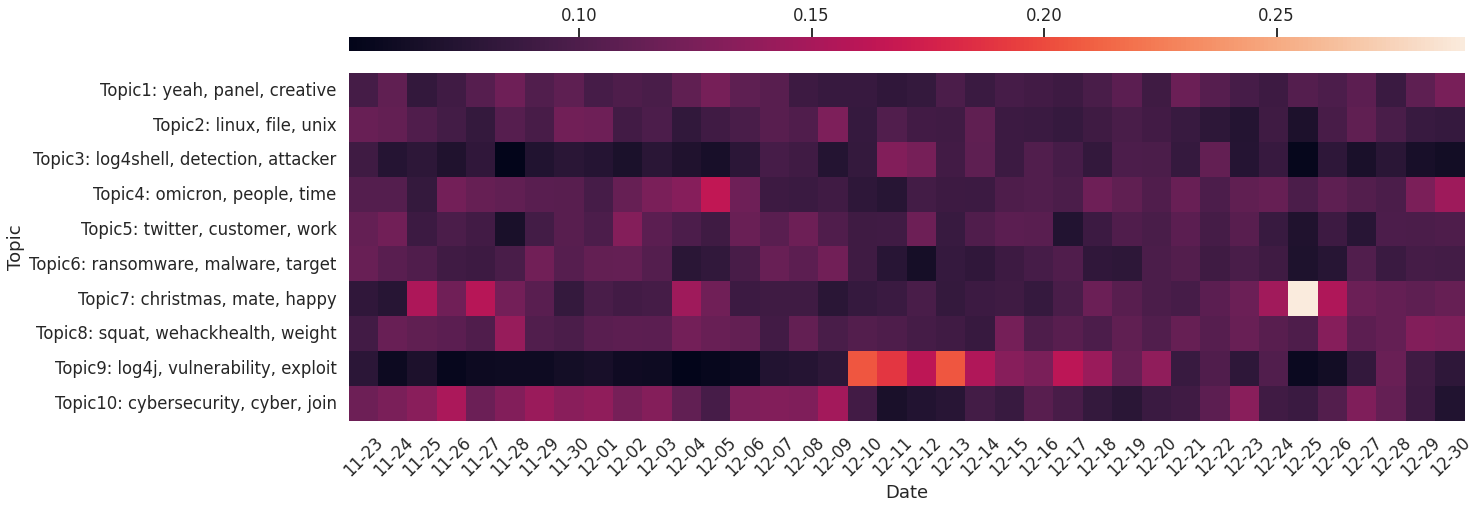

In [ ]:
ctm_avg_topics_over_time = plot_topics_overtime(ctm_toc_list, ctm_top_doc_matrix, new_list, date_list)

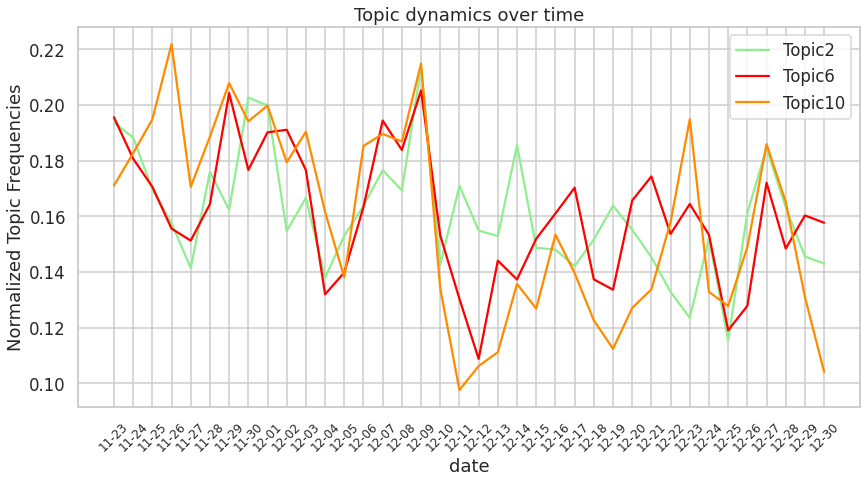

In [ ]:
plot_df = pd.DataFrame(ctm_avg_topics_over_time.T)

#SMALL_SIZE = 8
MEDIUM_SIZE = 10
#BIGGER_SIZE = 12

tickvalues = range(0,len(date_list))
plt.subplots(figsize=(14, 7))

plt.plot(normalize(plot_df.loc[1].values.reshape(1, -1))[0], label = 'Topic2', color='lightgreen') #12 dimension
plt.plot(normalize(plot_df.loc[5].values.reshape(1, -1))[0], label = 'Topic6', color='red') #12 dimension
# plt.plot(normalize(plot_df.loc[5].values.reshape(1, -1))[0],label = 'Topic6', color='dodgerblue')
# plt.plot(normalize(plot_df.loc[8].values.reshape(1, -1))[0],label = 'Topic9', color='darkorange')
plt.plot(normalize(plot_df.loc[9].values.reshape(1, -1))[0],label = 'Topic10', color='darkorange')
plt.legend(loc="upper right")


plt.grid(True)
plt.xlabel('date')
plt.ylabel('Normalized Topic Frequencies')
plt.rc('font', size=BIGGER_SIZE)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.xticks(ticks = tickvalues, labels = date_list, rotation = 45)
plt.title('Topic dynamics over time')
plt.savefig('CTM_T2610.svg', format='svg')
plt.show()